<a href="https://colab.research.google.com/github/krishnarevi/TSAI_END2.0_Session12/blob/main/NMT_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparing Data
First, we'll import all the modules as before, with the addition of the matplotlib modules used for viewing the attention.

We will be using Multi30k <http://www.statmt.org/wmt16/multimodal-task.html#task1>__ dataset to train a German to English translation model.

In [91]:
%%bash
pip install -U spacy --quiet
python -m spacy download en --quiet
python -m spacy download de --quiet

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the
full pipeline package name 'de_core_news_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


2021-07-31 12:19:47.985799: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-31 12:19:54.515302: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List

# from typing import Tuple
# from torch import Tensor
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import spacy
import numpy as np
import random
import math
import time

Next, we'll set the random seed for reproducability.

In [93]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True



## Data Sourcing and Processing
`torchtext` library has utilities for creating datasets that can be easily iterated through for the purposes of creating a language translation model. In this example, we show how to use torchtext's inbuilt datasets, tokenize a raw text sentence, build vocabulary, and numericalize tokens into tensor. We will use Multi30k dataset from torchtext library [here](https://pytorch.org/text/stable/datasets.html#multi30k) that yields a pair of source-target raw sentences.

In [94]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

In [95]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language="de_core_news_sm")
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language="en_core_web_sm")

In [96]:
# helper function to yield list of tokens

def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

In [97]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [98]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # Training data Iterator 
  train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  # Create torchtext's Vocab object 
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

In [99]:
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [100]:
vocab_transform[TGT_LANGUAGE](['I', 'wish', 'to', 'view', 'output'])

[1167, 0, 19, 459, 0]

In [101]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)

    return src_batch,tgt_batch


Create test data loader

In [102]:
test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))


Let's view one example from test set

In [103]:
next(iter(test_iter))

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.\n',
 'A man in an orange hat starring at something.\n')

SelfAttention

In [104]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        # Get number of training examples
        N = query.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)  # (N, value_len, heads, head_dim)
        keys = self.keys(keys)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out

TransformerBlock

In [105]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

 Encoder

In [106]:
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):

        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )
        

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(
            (self.word_embedding(x) + self.position_embedding(positions))
        )

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

DecoderBlock

In [107]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size, heads=heads)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

Decoder

In [108]:
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        #trg = [batch size, trg len]
        #enc_out = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        for layer in self.layers:
            # x = layer(x, enc_out, src_mask, trg_mask)
             x =layer(x, enc_out, enc_out, src_mask,  trg_mask)

        out = self.fc_out(x)

        return out

Transformer

In [109]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        device ,
        embed_size=512,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0,

        max_length=100,
    ):

        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out


In [110]:
# Training hyperparameters
# num_epochs = 100
# learning_rate = 3e-4
# batch_size = 32

# Model hyperparameters
src_vocab_size = len(vocab_transform[SRC_LANGUAGE])
trg_vocab_size = len(vocab_transform[TGT_LANGUAGE])
src_pad_idx = PAD_IDX
trg_pad_idx = PAD_IDX
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32

model = Transformer(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx,device =device).to(device)
# model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(device)
src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx

(19215, 10838, 1, 1)

In [111]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Transformer(
  (encoder): Encoder(
    (word_embedding): Embedding(19215, 512)
    (position_embedding): Embedding(100, 512)
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): SelfAttention(
          (values): Linear(in_features=64, out_features=64, bias=False)
          (keys): Linear(in_features=64, out_features=64, bias=False)
          (queries): Linear(in_features=64, out_features=64, bias=False)
          (fc_out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout): Dropout(p=0, inplace=False)
      )
      (1): TransformerBlock(
        (attention): SelfAttention(
          (values)

In [112]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 51,225,686 trainable parameters


In [113]:
optimizer = optim.Adam(model.parameters(),lr = 2e-4)

In [114]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)


Next, we'll define our training and evaluation loops.

In [115]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    for src, trg in train_dataloader:
        src = src.to(device)
        trg = trg.to(device)
        optimizer.zero_grad() 
            
        output = model(src, trg[:,:-1])#get rid of EOS token
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)


        loss = criterion(output, trg)
        loss.backward()
        clip = 1
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src,trg in val_dataloader:
        src = src.to(device)
        trg = trg.to(device)

        output = model(src, trg[:,:-1])#get rid of EOS token
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        loss = criterion(output, trg)
        losses += loss.item()

    return losses / len(val_dataloader)

In [116]:
from timeit import default_timer as timer
NUM_EPOCHS = 25

train_los=[]
val_los=[]
best_val_loss = float('inf')

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    train_los.append(train_loss)
    end_time = timer()
    val_loss = evaluate(model)
    val_los.append(val_loss)

        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'saved-model.pt')
    # print(f'\tEpoch: {epoch}')
    print(f'\t Epoch: {epoch}  | Epoch time : {(end_time - start_time):.3f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. PPL: {math.exp(val_loss):7.3f}')
    # print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f},Train PPL: {math.exp(train_loss):7.3f} "f"Epoch time = {(end_time - start_time):.3f}s"))

	 Epoch: 1  | Epoch time : 65.129s
	Train Loss: 6.000 | Train PPL: 403.242
	 Val. Loss: 5.435 |  Val. PPL: 229.355
	 Epoch: 2  | Epoch time : 64.965s
	Train Loss: 5.405 | Train PPL: 222.542
	 Val. Loss: 5.435 |  Val. PPL: 229.311
	 Epoch: 3  | Epoch time : 64.865s
	Train Loss: 5.392 | Train PPL: 219.732
	 Val. Loss: 5.451 |  Val. PPL: 232.967
	 Epoch: 4  | Epoch time : 64.851s
	Train Loss: 5.384 | Train PPL: 217.816
	 Val. Loss: 5.466 |  Val. PPL: 236.625
	 Epoch: 5  | Epoch time : 64.938s
	Train Loss: 5.374 | Train PPL: 215.680
	 Val. Loss: 5.465 |  Val. PPL: 236.279
	 Epoch: 6  | Epoch time : 64.851s
	Train Loss: 5.353 | Train PPL: 211.175
	 Val. Loss: 5.467 |  Val. PPL: 236.776
	 Epoch: 7  | Epoch time : 65.303s
	Train Loss: 5.344 | Train PPL: 209.391
	 Val. Loss: 5.474 |  Val. PPL: 238.444
	 Epoch: 8  | Epoch time : 64.825s
	Train Loss: 5.336 | Train PPL: 207.745
	 Val. Loss: 5.488 |  Val. PPL: 241.764
	 Epoch: 9  | Epoch time : 64.886s
	Train Loss: 5.329 | Train PPL: 206.229
	 Val

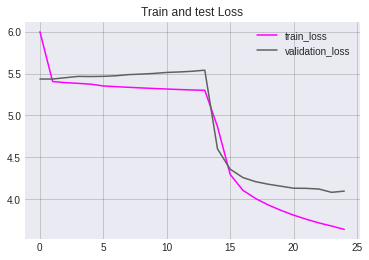

In [117]:

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(train_los, color = 'magenta')
plt.plot(val_los, color = '#606060')
plt.title('Train and test Loss')
plt.legend(['train_loss', 'validation_loss'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)